In [ ]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [ ]:
# Auto Encoder

from tensorflow.keras.datasets import mnist
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from sklearn.manifold import LocallyLinearEmbedding

tf.config.run_functions_eagerly(False)

class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim*4, activation='relu'),
      layers.Dense(latent_dim*2, activation='relu'),
      layers.Dense(latent_dim, activation='relu')
    ])
    self.decoder = tf.keras.Sequential([
        layers.Dense(latent_dim*2, activation='relu'),
        layers.Dense(latent_dim*4, activation='relu'),
        layers.Dense(tf.math.reduce_prod(shape), activation='sigmoid'),
        layers.Reshape(target_shape=shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [ ]:

class combine_loss():
  def __init__(self):
    self.Global_Index = 0

  def combined_loss(self, y_true, y_pred, autoencoder, X_transformed):
    # Reconstruction loss (MSE)
    reconstruction_loss = tf.reduce_mean(tf.square(y_true - y_pred))

    # Get the latent representation from the autoencoder
    encoded_data = autoencoder.encoder(y_true)

    # Calculate the MSE between the latent representation and the transformed data
    lle_loss = tf.reduce_mean(tf.square(encoded_data - X_transformed[self.Global_Index:self.Global_Index+10]))

    self.Global_Index = 10 + self.Global_Index if self.Global_Index < 191 else 0

    # Combine both losses with some weighting
    total_loss = 5*reconstruction_loss + lle_loss
    return total_loss


In [ ]:
# Load MNIST data
(x_train, y_train), (_, _) = mnist.load_data()

# sorted_indices = np.argsort(y_train)
# x_train = x_train[sorted_indices]
# y_train = y_train[sorted_indices]

# selected_indices = []
# classes_seen = np.zeros(10, dtype=int)

# for i, label in enumerate(y_train):
#     if classes_seen[label] < 10:
#         selected_indices.append(i)
#         classes_seen[label] += 1
#     if all(count == 10 for count in classes_seen):
#         break

# x_train = x_train[selected_indices]
# selected_y = y_train[selected_indices]


random_indices = np.random.choice(len(x_train), size=1000, replace=False)
x_train = x_train[random_indices]

print(x_train.shape)

x_train = x_train.astype('float32') / 255.


shape = x_train.shape[1:]
latent_dim = 350
latent_dim_sqrt = 8

lle = LocallyLinearEmbedding(n_components=latent_dim, n_neighbors=1)
X_lle = x_train.reshape(len(x_train), -1)
X_transformed = lle.fit_transform(X_lle)

custom_loss_ = combine_loss()

autoencoder = Autoencoder(latent_dim, shape)
autoencoder.compile(optimizer='adam', loss=lambda y_true, y_pred: custom_loss_.combined_loss(y_true, y_pred, autoencoder, X_transformed))
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_train,x_train), batch_size=10)

encoded_imgs = autoencoder.encoder(x_train).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
decoded_lle = autoencoder.decoder(X_transformed).numpy()

(1000, 28, 28)
Epoch 1/10
100/100 [==============================] - 18s 147ms/step - loss: 0.3641 - val_loss: 0.2790
Epoch 2/10
100/100 [==============================] - 16s 158ms/step - loss: 0.2417 - val_loss: 0.2144
Epoch 3/10
100/100 [==============================] - 8s 78ms/step - loss: 0.2046 - val_loss: 0.1841
Epoch 4/10
100/100 [==============================] - 9s 85ms/step - loss: 0.1818 - val_loss: 0.1693
Epoch 5/10
100/100 [==============================] - 7s 72ms/step - loss: 0.1666 - val_loss: 0.1530
Epoch 6/10
100/100 [==============================] - 8s 80ms/step - loss: 0.1553 - val_loss: 0.1453
Epoch 7/10
100/100 [==============================] - 9s 86ms/step - loss: 0.1447 - val_loss: 0.1318
Epoch 8/10
100/100 [==============================] - 7s 73ms/step - loss: 0.1358 - val_loss: 0.1274
Epoch 9/10
100/100 [==============================] - 8s 79ms/step - loss: 0.1275 - val_loss: 0.1173
Epoch 10/10
100/100 [==============================] - 7s 69ms/step - lo

In [ ]:
plt.subplot(1, 2, 1)
plt.scatter(encoded_imgs[:,1], encoded_imgs[:,2])
plt.subplot(1, 2, 2)
plt.scatter(X_transformed[:,0], X_transformed[:,1])
plt.show()

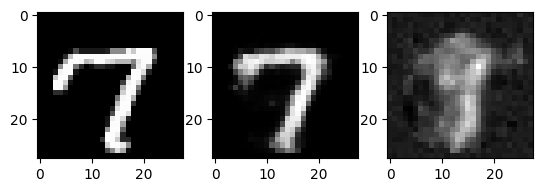

In [ ]:
index = 25
plt.subplot(1, 3, 1)
plt.imshow(x_train[index], cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(decoded_imgs[index].reshape(28, 28), cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(decoded_lle[index].reshape(28, 28), cmap='gray')
plt.show()